# From Soham Pawar - Colorization Model Training on CIFAR-10 as teached and inspired from the training program

- **Evaluation Metric:**  
  We use Mean Squared Error (MSE) as our sole evaluation metric because colorization is a regression task. Metrics like confusion matrix, precision, recall, and accuracy are more suitable for classification/segmentation tasks.

- **Model Creation Logic:**  
  This notebook builds a colorization model from scratch using the CIFAR-10 dataset. The model is an encoder–decoder network that predicts the ab channels from the L channel of LAB images. The network is trained with MSE loss, and both the model weights and the complete model are saved for future use.


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from skimage import color
import matplotlib.pyplot as plt
from tqdm import tqdm
torch.manual_seed(42)
import random
random.seed(42)
import numpy as np
np.random.seed(42)

In [10]:
class CIFAR10Colorization(Dataset):
    def __init__(self, train=True):
        # this is to download CIFAR-10
        self.dataset = torchvision.datasets.CIFAR10(root='./data', train=train, download=True)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]  # we ignore the label
        image_np = np.array(image)
        # here we normalize to [0, 1] for skimage
        image_float = image_np.astype(np.float32) / 255.0
        lab = color.rgb2lab(image_float)
        L = lab[:, :, 0] / 100.0
        ab = lab[:, :, 1:] / 128.0
        # and then convert to torch tensors
        L_tensor = torch.from_numpy(L).unsqueeze(0).float()  # shape: (1, H, W)
        ab_tensor = torch.from_numpy(ab).permute(2, 0, 1).float()  # shape: (2, H, W)
        return L_tensor, ab_tensor

# here i have created training and validation datasets
train_dataset = CIFAR10Colorization(train=True)
val_dataset = CIFAR10Colorization(train=False)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

In [11]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  # downsampleed: 32x32 -> 16x16
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # upsampled: 16x16 -> 32x32
            nn.ReLU(),
            nn.Conv2d(64, 2, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        features = self.encoder(x)
        ab_channels = self.decoder(features)
        return ab_channels

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ColorizationNet().to(device)
# using Mean Squared Error Loss
criterion = nn.MSELoss()
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print(f"Training on device: {device}")

Training on device: cuda


In [13]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for L_tensor, ab_tensor in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        L_tensor, ab_tensor = L_tensor.to(device), ab_tensor.to(device)
        optimizer.zero_grad()
        output = model(L_tensor)
        loss = criterion(output, ab_tensor)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * L_tensor.size(0)

    train_loss /= len(train_loader.dataset)

    # now to evaluate on validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for L_tensor, ab_tensor in val_loader:
            L_tensor, ab_tensor = L_tensor.to(device), ab_tensor.to(device)
            output = model(L_tensor)
            loss = criterion(output, ab_tensor)
            val_loss += loss.item() * L_tensor.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} -- Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/10: 100%|██████████| 391/391 [00:20<00:00, 18.95it/s]


Epoch 1/10 -- Train Loss: 0.0106, Val Loss: 0.0104


Epoch 2/10: 100%|██████████| 391/391 [00:20<00:00, 19.19it/s]


Epoch 2/10 -- Train Loss: 0.0101, Val Loss: 0.0101


Epoch 3/10: 100%|██████████| 391/391 [00:20<00:00, 19.54it/s]


Epoch 3/10 -- Train Loss: 0.0099, Val Loss: 0.0099


Epoch 4/10: 100%|██████████| 391/391 [00:19<00:00, 19.77it/s]


Epoch 4/10 -- Train Loss: 0.0098, Val Loss: 0.0097


Epoch 5/10: 100%|██████████| 391/391 [00:19<00:00, 19.98it/s]


Epoch 5/10 -- Train Loss: 0.0097, Val Loss: 0.0096


Epoch 6/10: 100%|██████████| 391/391 [00:20<00:00, 18.84it/s]


Epoch 6/10 -- Train Loss: 0.0097, Val Loss: 0.0097


Epoch 7/10: 100%|██████████| 391/391 [00:19<00:00, 20.16it/s]


Epoch 7/10 -- Train Loss: 0.0096, Val Loss: 0.0096


Epoch 8/10: 100%|██████████| 391/391 [00:20<00:00, 19.26it/s]


Epoch 8/10 -- Train Loss: 0.0096, Val Loss: 0.0095


Epoch 9/10: 100%|██████████| 391/391 [00:20<00:00, 19.39it/s]


Epoch 9/10 -- Train Loss: 0.0096, Val Loss: 0.0095


Epoch 10/10: 100%|██████████| 391/391 [00:20<00:00, 18.93it/s]


Epoch 10/10 -- Train Loss: 0.0096, Val Loss: 0.0095


## Saving the Model
here the model are saved

In [14]:
# save only the model weights
torch.save(model.state_dict(), "colorization_model_weights.pth")
# save the complete model
torch.save(model, "colorization_model_complete.pth")
print("Model saved as colorization_model_weights.pth and colorization_model_complete.pth")

Model saved as colorization_model_weights.pth and colorization_model_complete.pth


## To download these files:
 i have to run this code down below also works only if using on colab.

In [15]:
try:
    from google.colab import files
    print("Downloading model weights...")
    files.download("colorization_model_weights.pth")
    print("Downloading complete model...")
    files.download("colorization_model_complete.pth")
except ImportError:
    print("Not running in Colab; skip file download step.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

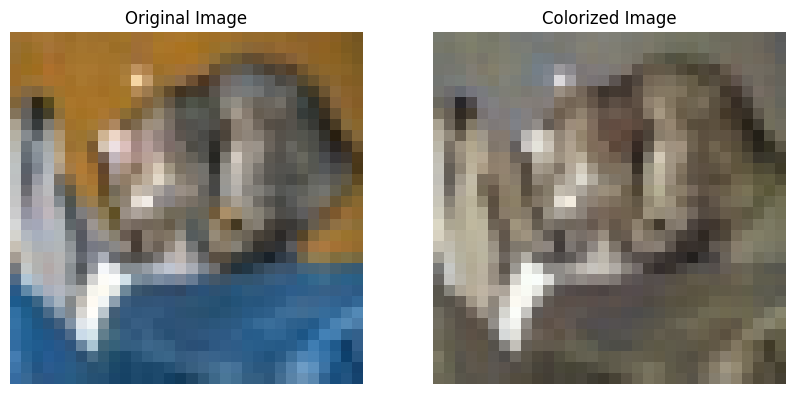

In [16]:
# setting model to evaluation mode
model.eval()

with torch.no_grad():
    L_tensor, ab_tensor = val_dataset[0]  # first sample
    L_tensor_input = L_tensor.unsqueeze(0).to(device)
    pred_ab = model(L_tensor_input).cpu().squeeze(0)

L_np = L_tensor.squeeze(0).numpy() * 100.0  # scale back to [0, 100]
pred_ab_np = pred_ab.numpy() * 128.0
lab_reconstructed = np.zeros((32, 32, 3))
lab_reconstructed[:, :, 0] = L_np
lab_reconstructed[:, :, 1:] = np.transpose(pred_ab_np, (1, 2, 0))
rgb_reconstructed = np.clip(color.lab2rgb(lab_reconstructed.astype(np.float64)), 0, 1)
original_img = np.array(val_dataset.dataset[0][0])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rgb_reconstructed)
plt.title("Colorized Image")
plt.axis('off')

plt.show()